In [1]:
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

from netam.common import print_parameter_count

from netam import framework, models

from shmex.shm_data import train_val_dfs_of_nickname
from shmex.shm_zoo import default_burrito_params
from shmex.local import localify

figures_dir = localify('FIGURES_DIR')

Using Metal Performance Shaders


In [2]:
! mkdir -p _ignore/original_shmoof
! mkdir -p _ignore/reshmoof
! curl -o _ignore/original_shmoof/mutabilities_context.tsv https://raw.githubusercontent.com/statbiophys/shmoof/master/mutabilities_context.tsv
! curl -o _ignore/original_shmoof/mutabilities_position.tsv https://raw.githubusercontent.com/statbiophys/shmoof/master/mutabilities_position.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89008  100 89008    0     0   340k      0 --:--:-- --:--:-- --:--:--  340k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9242  100  9242    0     0  30834      0 --:--:-- --:--:-- --:--:-- 30909


In [3]:
train_df, val_df = train_val_dfs_of_nickname('shmoof_small')

Interpreting shmoof_small as a shmoof dataset


In [4]:
kmer_length = 5
site_count = 410
weight_decay = 1e-6

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 46391 training examples and 2625 validation examples


### Our "reshmoof" fitting of the shmoof model has good agreement with the original fit

In [5]:
model = models.SHMoofModel(kmer_length=kmer_length, site_count=site_count)
print_parameter_count(model)
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, **default_burrito_params)
losses = burrito.train(epochs=100)

model.write_shmoof_output("_ignore/reshmoof")

kmer_embedding: 1025 parameters
log_site_rates: 410 parameters
-----
total: 1435 parameters


Epoch: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it, loss_diff=-4.746e-06, lr=0.001, val_loss=0.05568]


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_motif_mutabilities(shmoof_motifs, reshmoof_motifs, ax=None, title='Comparison of Motif Mutabilities: Shmoof vs. Reshmoof'):
    """
    Plot a scatter plot of motif mutabilities between two datasets.
    """
    # Merge dataframes
    merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

    # Create an axis if not supplied
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot
    ax.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

    # Determine bounds for y=x line
    min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
    max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

    # Add y=x line
    ax.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

    # Set labels and title
    ax.set_xlabel('Shmoof Mutability')
    ax.set_ylabel('Reshmoof Mutability')
    ax.set_title(title)
    ax.grid(True)


def plot_position_mutabilities(shmoof_positions, reshmoof_positions, ax=None, title='Comparison of Position Mutabilities: Shmoof vs. Reshmoof'):
    """
    Plot a line plot comparing position mutabilities between two datasets.
    """
    # Merge and sort dataframes
    merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
    merged_positions.sort_values(by='Position', inplace=True)

    # Create an axis if not supplied
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Line plot
    ax.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
    ax.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
    
    # Set labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Mutability')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

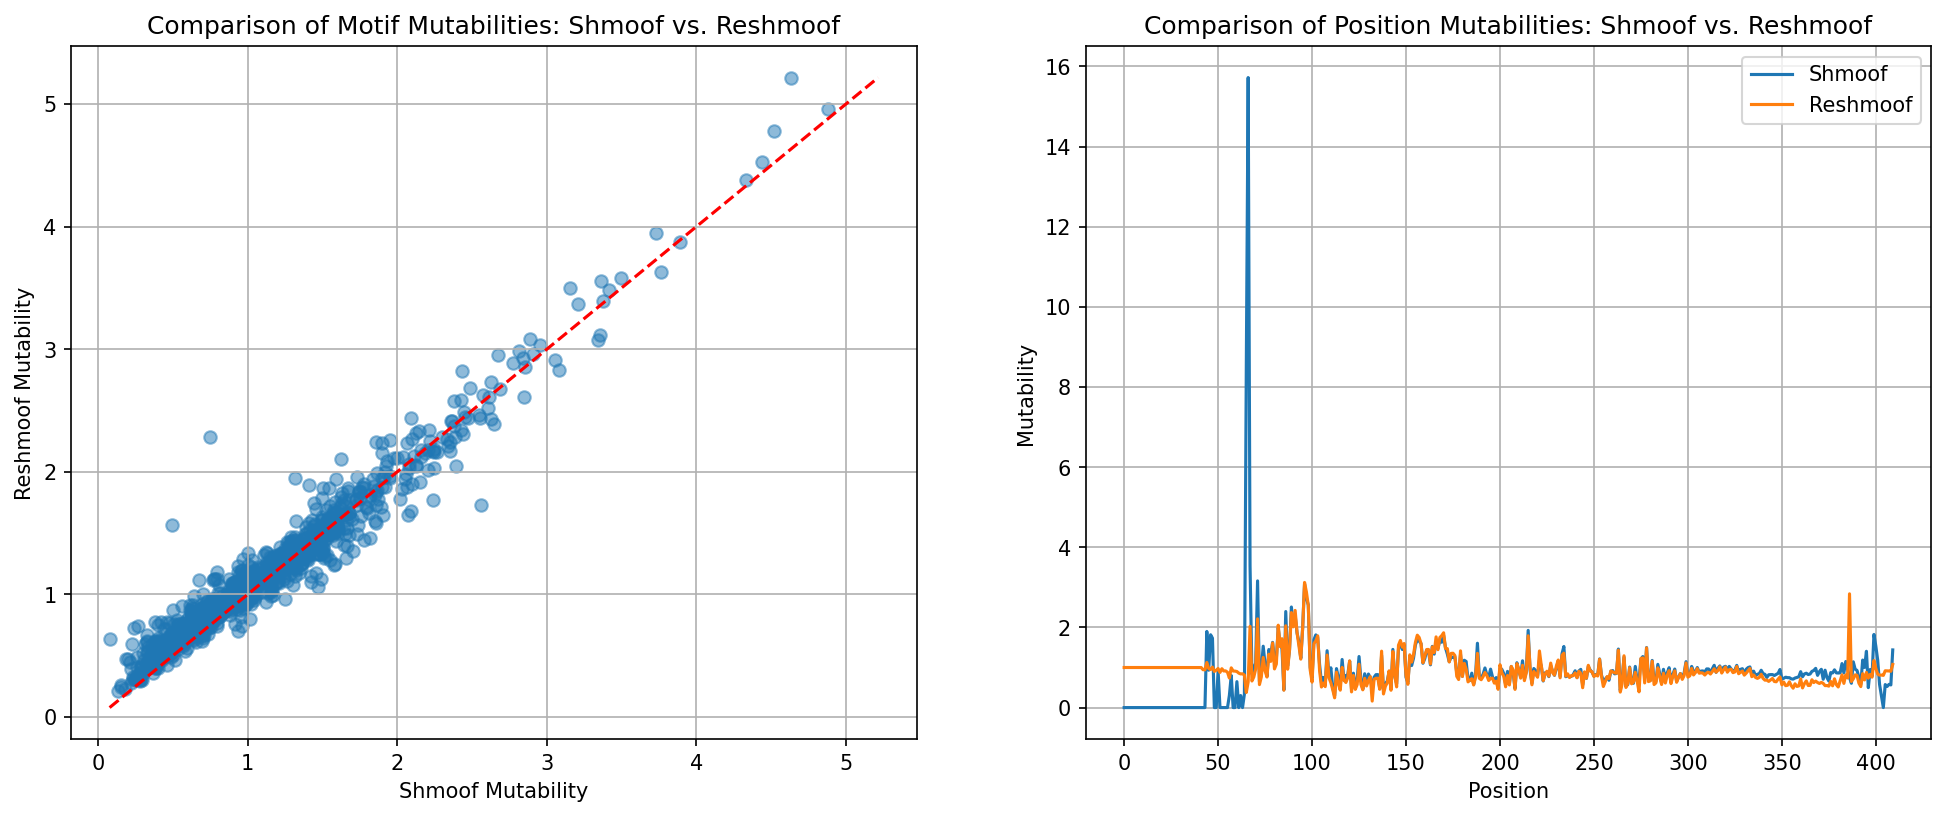

In [7]:
# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
# reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')
reshmoof_mutabilities = torch.exp(model.kmer_embedding.weight).squeeze().detach().numpy()
reshmoof_motifs = pd.DataFrame({'Mutability': reshmoof_mutabilities, 'Motif': train_dataset.encoder.kmer_to_index.keys()})

# We have a slight amount of regularization, which smooths out the per-site mutability when the data is weak.
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
shmoof_positions["Position"] -= 1
reshmoof_positions = torch.exp(model.log_site_rates.weight).squeeze().detach().numpy()
reshmoof_positions = pd.DataFrame({'Position': np.arange(len(reshmoof_positions)), 'Mutability': reshmoof_positions})

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plot_motif_mutabilities(shmoof_motifs, reshmoof_motifs, ax=axs[0])
plot_position_mutabilities(shmoof_positions, reshmoof_positions, ax=axs[1])

fig.savefig(figures_dir + 'shmoof_vs_reshmoof_mutabilities.svg')

### Taking the average of the k-mer based sitewise mutability shows a pattern similar to the original sitewise mutability

In [8]:
kmer_mutabilities = []

merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# turn reshmoof_motifs into a dict mapping "Motif" to "Mutability"
reshmoof_motifs_dict = dict(zip(reshmoof_motifs["Motif"], reshmoof_motifs["Mutability"]))

for parent in train_df["parent"]:
    kmer_mutability = np.ones(site_count)
    padded_parent = "NN" + parent + "NN"
    for i in range(min(410, len(padded_parent) - 5)):
        kmer_mutability[i] = reshmoof_motifs_dict.get(padded_parent[i:i+5], 1.0)
    kmer_mutabilities.append(kmer_mutability)

[kmer_mutability.shape for kmer_mutability in kmer_mutabilities]

mean_sitewise_mutability = np.stack(kmer_mutabilities).mean(axis=0)
mean_sitewise_mutability = pd.Series(mean_sitewise_mutability)

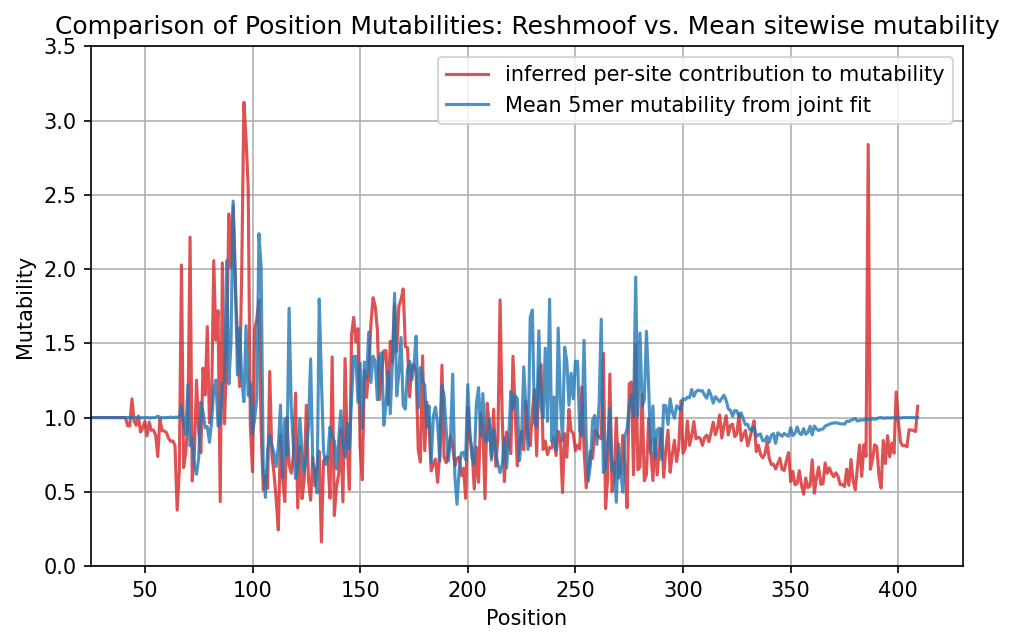

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='inferred per-site contribution to mutability', color='tab:red', alpha=0.8)
ax.plot(merged_positions['Position'], mean_sitewise_mutability, label='Mean 5mer mutability from joint fit', color='tab:blue', alpha=0.8)
ax.set_xlabel('Position')
ax.set_ylabel('Mutability')
ax.set_title('Comparison of Position Mutabilities: Reshmoof vs. Mean sitewise mutability')
ax.set_xlim(25, 430)
ax.set_ylim(0, 3.5)
ax.legend()
ax.grid(True)
# save to svg
fig.savefig(figures_dir + 'reshmoof_vs_mean_sitewise_mutability.svg', format='svg')
#fig.savefig(figures_dir + 'reshmoof_vs_mean_sitewise_mutability.1.svg', format='svg')

### We still get a per-site signal even if we fit the kmer component first

In [10]:
def set_requires_grad(model, attr_name, value):
    for param in getattr(model, attr_name).parameters():
        param.requires_grad = value

with torch.no_grad():
    model.log_site_rates.weight.data.zero_()

epochs = 100

model = models.SHMoofModel(kmer_length=kmer_length, site_count=site_count)
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, weight_decay=weight_decay)

# First train the kmer embedding...
set_requires_grad(model, 'kmer_embedding', True)
set_requires_grad(model, 'log_site_rates', False)

burrito.train(epochs=epochs)

kmer_embedding_stored = model.kmer_embedding.weight.data.clone()

# ...then train the log site rates, fixing the kmer embedding.
# We make a new burrito because we want a new optimizer and scheudler.
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, weight_decay=weight_decay)
# We get a slightly better fit by decreasing the learning rate.
set_requires_grad(model, 'kmer_embedding', False)
set_requires_grad(model, 'log_site_rates', True)

loss_history = burrito.train(epochs=epochs)

# Double check that the second round of training didn't change the kmer embedding
assert torch.allclose(kmer_embedding_stored, model.kmer_embedding.weight.data)

loss_history.tail()

Epoch: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it, loss_diff=0, lr=0.000195, val_loss=0.06122]


,train_loss,val_loss
95,0.067074,0.061218
96,0.067072,0.061218
97,0.067076,0.061218
98,0.067075,0.061218
99,0.067075,0.061218


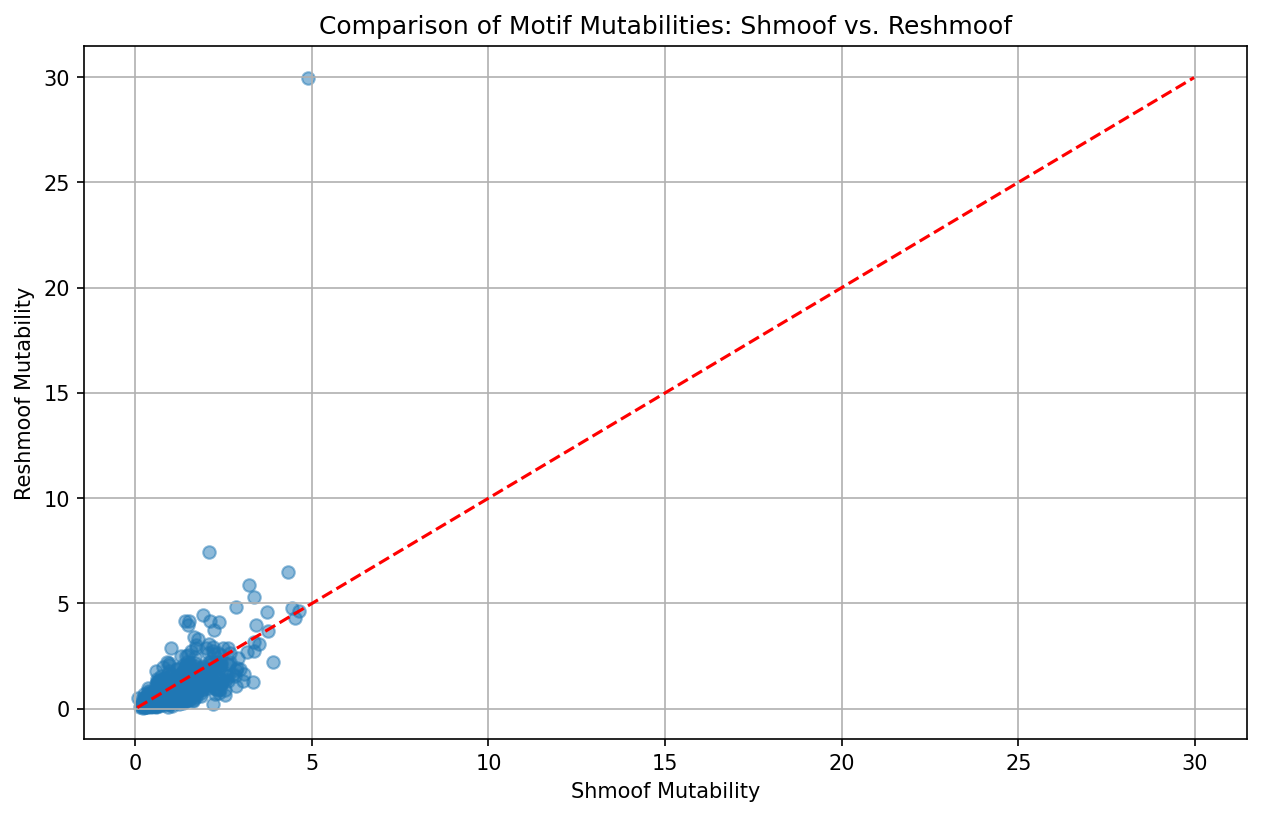

In [11]:
reshmoof_mutabilities = torch.exp(model.kmer_embedding.weight).squeeze().detach().numpy()
reshmoof_motifs = pd.DataFrame({'Mutability': reshmoof_mutabilities, 'Motif': train_dataset.encoder.kmer_to_index.keys()})

plot_motif_mutabilities(shmoof_motifs, reshmoof_motifs)


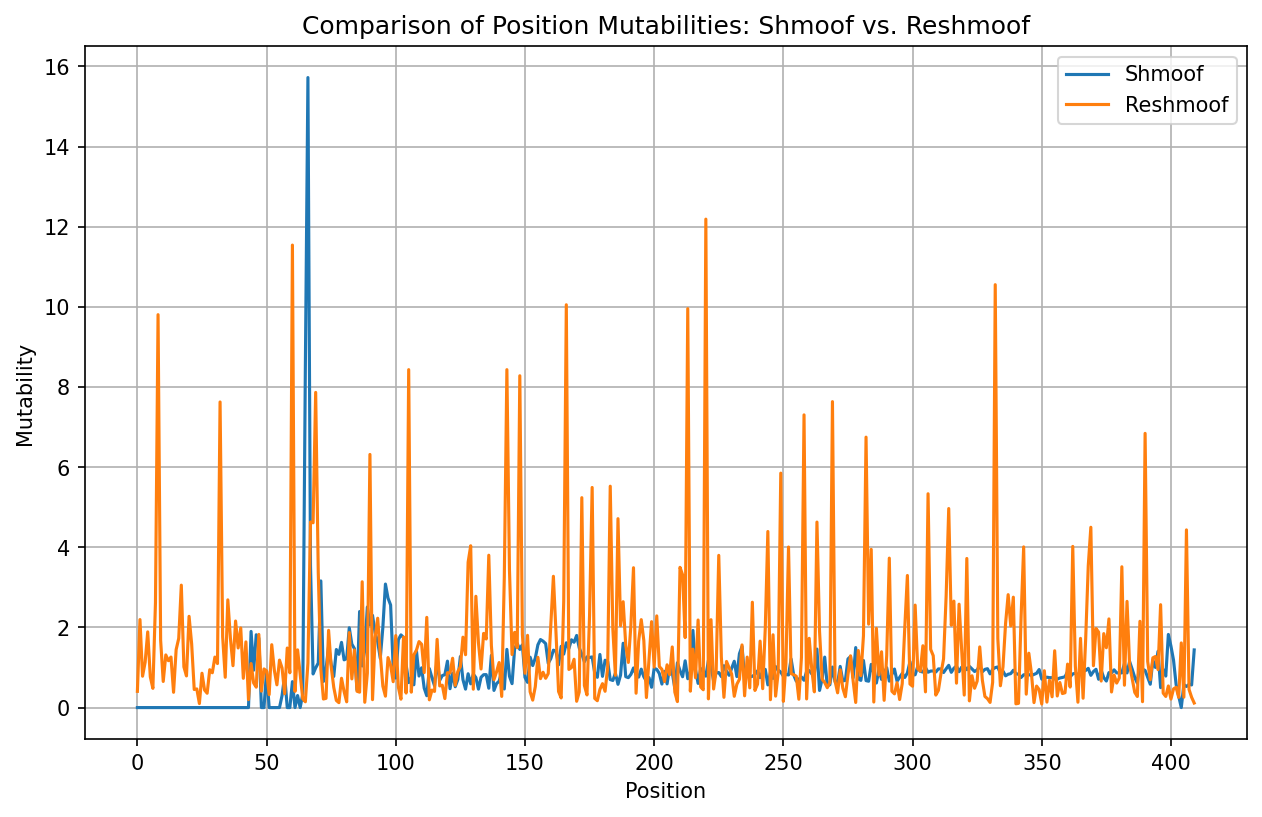

In [12]:
reshmoof_positions = torch.exp(model.log_site_rates.weight).squeeze().detach().numpy()
reshmoof_positions = pd.DataFrame({'Position': np.arange(len(reshmoof_positions)), 'Mutability': reshmoof_positions})
plot_position_mutabilities(shmoof_positions, reshmoof_positions)

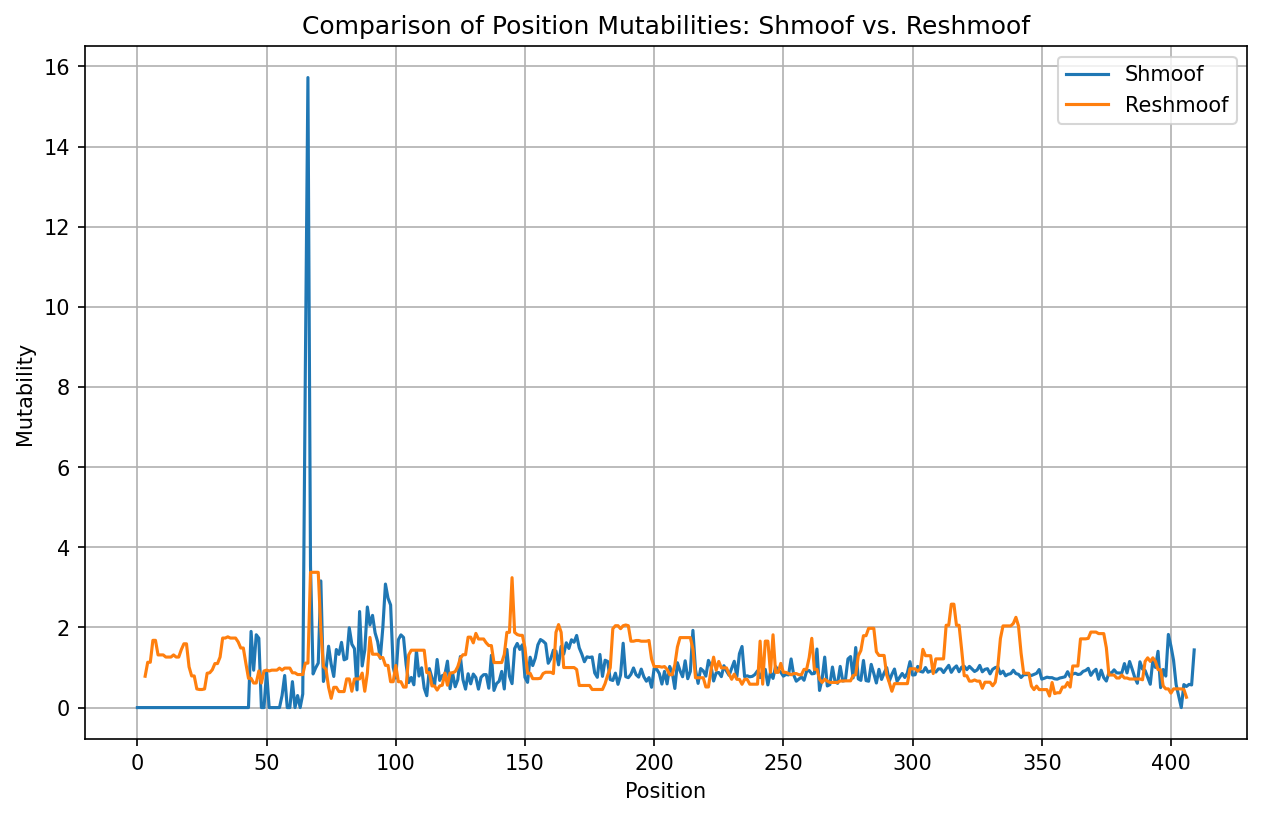

In [13]:
# take a sliding window of width 7 and apply to reshmoof_positions
reshmoof_positions_sliding = reshmoof_positions.copy()
reshmoof_positions_sliding["Mutability"] = reshmoof_positions["Mutability"].rolling(window=7, center=True).median()
plot_position_mutabilities(shmoof_positions, reshmoof_positions_sliding)

Training with regularization coefficient 0


Epoch: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it, loss_diff=2.31e-07, lr=0.000781, val_loss=0.05573] 


Training with regularization coefficient 1e-08


Epoch: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it, loss_diff=7.339e-07, lr=0.000781, val_loss=0.05572]


Training with regularization coefficient 1e-07


Epoch: 100%|██████████| 100/100 [02:34<00:00,  1.54s/it, loss_diff=9.313e-08, lr=0.000781, val_loss=0.0557]


Training with regularization coefficient 1e-06


Epoch: 100%|██████████| 100/100 [02:31<00:00,  1.52s/it, loss_diff=-6.668e-07, lr=0.000781, val_loss=0.05562]


Training with regularization coefficient 1e-05


Epoch: 100%|██████████| 100/100 [02:31<00:00,  1.51s/it, loss_diff=1.989e-06, lr=0.00313, val_loss=0.05553]


Training with regularization coefficient 0.0001


Epoch: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it, loss_diff=-5.215e-08, lr=0.000781, val_loss=0.0561]


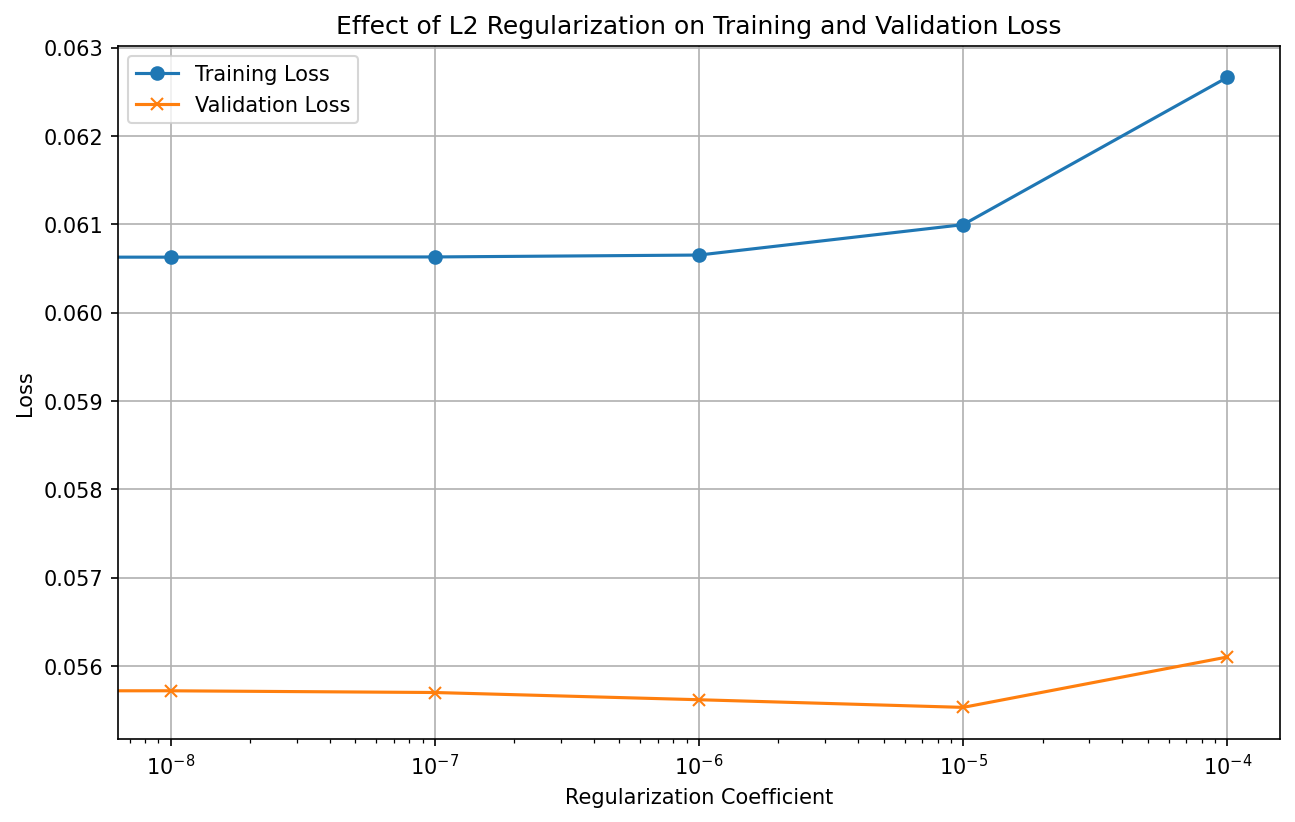

,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.060628,0.055726
1,1.000000e-08,0.060629,0.055722
2,1.000000e-07,0.060631,0.055703
3,1.000000e-06,0.060653,0.055621
4,1.000000e-05,0.060997,0.055534
5,1.000000e-04,0.062663,0.056105


In [14]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = models.SHMoofModel(kmer_length=kmer_length, site_count=site_count)
    burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, weight_decay=coeff)
    loss_history = burrito.train(epochs=100)
    final_training_loss = loss_history['train_loss'].iloc[-1]
    final_validation_loss = loss_history['val_loss'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

regularization_results_df